# Galaxy Examples - Transposed Grid

This notebook creates a transposed version of the galaxy examples grid from BYOL analysis.
- Layout: 4 rows (galaxies) × 3 columns (visualization types)
- Galaxies: 2 merger candidates, 1 undisturbed, 1 fragmented
- Visualizations: HSC i-band, HSC i-band (LSB), Starlet HF

In [1]:
cd ../byol

/Users/kadofong/work/projects/merian/pieridae/scripts/byol


In [2]:
import os
import subprocess
import sys
import torch
import numpy as np
import yaml
from pathlib import Path
from tqdm import tqdm
import glob
import pickle
import pandas as pd
from torchvision import models, transforms
from torch import nn
from byol_pytorch import BYOL
import matplotlib.pyplot as plt
from matplotlib import colors
from ekfplot import plot as ek
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

print("📦 Imports completed successfully")

📦 Imports completed successfully


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [154]:
### from carpenter import pixels
from astropy.visualization import make_lupton_rgb

In [3]:
from carpenter import conventions
from pieridae.starbursts import sample

## Device Setup

In [4]:
def setup_device():
    """Setup device with MPS support for Apple Silicon"""
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f"✅ Using Apple Silicon GPU (MPS): {device}")
        torch.mps.set_per_process_memory_fraction(0.8)
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✅ Using NVIDIA GPU: {device}")
    else:
        device = torch.device('cpu')
        print(f"Using CPU: {device}")
        torch.set_num_threads(os.cpu_count())
    return device

device = setup_device()

✅ Using Apple Silicon GPU (MPS): mps


In [5]:
catalog, masks = sample.load_sample('/Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet')

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.6 seconds.
Computed internal extinction corrections in 0.6 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [171]:
datadir = '../../local_data/pieridae_output/starlet/msorabove_v0/'
for sid in tqdm(catalog.index):
    filename = f'{datadir}/{sid}/{sid}_i_results.pkl'
    if not os.path.exists(filename):
        continue
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    catalog.loc[sid, 'logmass_adjusted'] = x['logmass_adjusted']
catalog.loc[catalog['logmass_adjusted'].isna(),'logmass_adjusted'] = catalog.loc[catalog['logmass'].isna(),'logmass_adjusted']

100%|███████████████████████████████████████████████████| 196667/196667 [00:25<00:00, 7691.96it/s]


## Configuration and Data Loading

In [6]:
def load_config(config_path: str):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load configuration
config_path = 'byol_config.yaml'
config = load_config(config_path)

# Convert paths to Path objects
config['data']['input_path'] = Path(config['data']['input_path'])
config['data']['output_path'] = Path(config['data']['output_path'])

print(f"📋 Configuration loaded from: {config_path}")
print(f"📁 Input path: {config['data']['input_path']}")
print(f"📁 Output path: {config['data']['output_path']}")
print(f"🖼️  Image size: {config['model']['image_size']}")

📋 Configuration loaded from: byol_config.yaml
📁 Input path: ../../local_data/pieridae_output/starlet/msorabove_v0
📁 Output path: ../../local_data/byol_results
🖼️  Image size: 150


In [7]:
def load_data(data_path: Path):
    """Load image data from pickle files"""
    print(f"🔍 Loading image data from: {data_path}")
    
    pattern = f"{data_path}/M*/*i_results.pkl"
    filenames = glob.glob(pattern)
    
    if not filenames:
        raise FileNotFoundError(f"No files found matching pattern: {pattern}")
    
    print(f"📸 Found {len(filenames)} image files")
    
    imgs = []
    img_names = []
    
    for fname in tqdm(filenames, desc="Loading images"):
        img = []
        for band in 'gi':
            current_filename = fname.replace('_i_', f'_{band}_')
            
            try:
                with open(current_filename, 'rb') as f:
                    xf = pickle.load(f)
                    img.append(xf['image'])
                    if band == 'i':
                        img.append(xf['hf_image'])
            except FileNotFoundError:
                print(f"⚠️  File not found: {current_filename}")
                continue
        
        if len(img) == 3:  # Only add if we have all bands
            imgs.append(np.array(img))
            img_names.append(Path(fname).parent.name)
    
    images = np.array(imgs)
    img_names = np.array(img_names)
    
    print(f"✅ Loaded {len(images)} images with shape: {images.shape}")
    return images, img_names

# Load images
images, img_names = load_data(config['data']['input_path'])

🔍 Loading image data from: ../../local_data/pieridae_output/starlet/msorabove_v0
📸 Found 22913 image files


Loading images: 100%|██████████████████████████████████████| 22913/22913 [00:44<00:00, 509.64it/s]


✅ Loaded 22913 images with shape: (22913, 3, 150, 150)


## BYOL Model Setup and Embedding Extraction

In [8]:
def setup_byol_model(config, device):
    """Setup BYOL model for inference"""
    print("🤖 Setting up BYOL model...")
    
    # Data augmentations
    transform1 = nn.Sequential(
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
    )
    
    transform2 = nn.Sequential(
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
    )
    
    # Base model
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # BYOL learner
    learner = BYOL(
        resnet,
        image_size=config['model']['image_size'],
        hidden_layer='avgpool',
        projection_size=config['model']['projection_size'],
        projection_hidden_size=config['model']['projection_hidden_size'],
        moving_average_decay=config['model']['moving_average_decay'],
        use_momentum=True,
        augment_fn=transform1,
        augment_fn2=transform2
    ).to(device)
    
    print(f"✅ BYOL model setup complete on {device}")
    return learner

def load_trained_model(learner, output_path: Path, device):
    """Load trained model weights"""
    model_path = output_path / 'byol_final_model.pt'
    
    if not model_path.exists():
        model_path = output_path / 'model_checkpoint.pt'
        
    if not model_path.exists():
        raise FileNotFoundError(f"No trained model found in {output_path}")
    
    print(f"📥 Loading trained model from: {model_path}")
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    if 'model_state_dict' in checkpoint:
        learner.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ Model loaded successfully")
    else:
        learner.load_state_dict(checkpoint)
        print(f"✅ Model loaded successfully (direct state dict)")
    
    learner.eval()
    return learner

# Setup and load model
learner = setup_byol_model(config, device)
learner = load_trained_model(learner, config['data']['output_path'], device)

🤖 Setting up BYOL model...
✅ BYOL model setup complete on mps
📥 Loading trained model from: ../../local_data/byol_results/byol_final_model.pt
✅ Model loaded successfully


In [9]:
def extract_embeddings(learner, images, device, batch_size=128):
    """Extract embeddings from images using trained BYOL model"""
    print(f"🧠 Extracting embeddings from {len(images)} images...")
    
    learner.eval()
    all_embeddings = []
    
    if device.type == 'mps':
        batch_size = min(64, batch_size)
    
    num_batches = (len(images) + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for i in tqdm(range(num_batches), desc="Extracting embeddings"):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images))
            
            batch = torch.tensor(
                images[start_idx:end_idx],
                dtype=torch.float32
            ).to(device)
            
            try:
                _, embeddings = learner(batch, return_embedding=True)
                all_embeddings.append(embeddings.cpu().numpy())
            except RuntimeError as e:
                if "MPS" in str(e) and device.type == 'mps':
                    print(f"⚠️  MPS error, falling back to CPU for batch {i}")
                    batch = batch.cpu()
                    learner_cpu = learner.cpu()
                    _, embeddings = learner_cpu(batch, return_embedding=True)
                    all_embeddings.append(embeddings.cpu().numpy())
                    learner = learner.to(device)
                else:
                    raise e
    
    embeddings = np.vstack(all_embeddings)
    print(f"✅ Extracted embeddings shape: {embeddings.shape}")
    
    return embeddings

# Extract embeddings
embeddings = extract_embeddings(
    learner, 
    images, 
    device, 
    batch_size=config['inference']['batch_size']
)

🧠 Extracting embeddings from 22913 images...


Extracting embeddings: 100%|████████████████████████████████████| 359/359 [00:37<00:00,  9.56it/s]


✅ Extracted embeddings shape: (22913, 512)


## Dimensionality Reduction (PCA + UMAP)

In [10]:
def compute_pca_umap(embeddings, config):
    """Apply PCA and UMAP to embeddings"""
    print("🔄 Computing PCA and UMAP...")
    
    # Clean data
    embeddings_clean = np.nan_to_num(
        embeddings, nan=0.0, posinf=0.0, neginf=0.0
    )
    
    # Standardization
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings_clean)
    
    # PCA
    pca_components = config['analysis']['pca_components']
    if pca_components is None:
        pca_full = PCA()
        pca_full.fit(embeddings_scaled)
        cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
        threshold = config['analysis']['explained_variance_threshold']
        pca_components = np.argmax(cumsum_var >= threshold) + 1
    
    max_components = min(
        embeddings_scaled.shape[0] - 1,
        embeddings_scaled.shape[1]
    )
    pca_components = min(pca_components, max_components)
    
    pca = PCA(n_components=pca_components, random_state=42)
    embeddings_pca = pca.fit_transform(embeddings_scaled)
    
    # UMAP
    n_neighbors = min(
        config['analysis']['n_neighbors'],
        len(embeddings_pca) - 1
    )
    
    umap_reducer = umap.UMAP(
        n_components=config['analysis']['umap_components'],
        n_neighbors=n_neighbors,
        min_dist=config['analysis']['min_dist'],
        metric=config['analysis']['metric'],
        random_state=42,
        verbose=True
    )
    
    embeddings_umap = umap_reducer.fit_transform(embeddings_pca)
    
    print(f"✅ PCA components: {pca_components}")
    print(f"✅ UMAP embedding shape: {embeddings_umap.shape}")
    
    return {
        'scaler': scaler,
        'pca': pca,
        'umap': umap_reducer,
        'embeddings_original': embeddings_clean,
        'embeddings_pca': embeddings_pca,
        'embeddings_umap': embeddings_umap
    }

# Compute PCA and UMAP
reduction_results = compute_pca_umap(embeddings, config)
pca = reduction_results['pca']
print(f'Explained variance: {pca.explained_variance_ratio_.sum()*100:.1f} pct')

🔄 Computing PCA and UMAP...


/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(min_dist=0.01, n_jobs=1, random_state=42, verbose=True)
Thu Oct  9 12:33:59 2025 Construct fuzzy simplicial set
Thu Oct  9 12:33:59 2025 Finding Nearest Neighbors
Thu Oct  9 12:33:59 2025 Building RP forest with 13 trees
Thu Oct  9 12:34:04 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Oct  9 12:34:08 2025 Finished Nearest Neighbor Search
Thu Oct  9 12:34:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Oct  9 12:34:18 2025 Finished embedding
✅ PCA components: 10
✅ UMAP embedding shape: (22913, 2)
Explained variance: 85.2 pct


## Load Classification Labels and Compute Probabilities

In [11]:
def load_labels(config, img_names):
    """Load classification labels"""
    labels = None
    label_file = Path(config.get('labels', {}).get('classifications_file', './classifications_kadofong_20250929.csv'))
    
    if label_file.exists() and img_names is not None:
        try:
            mergers = pd.read_csv(label_file, index_col=0)
            labels = mergers.reindex(img_names)
            labels = labels.replace(np.nan, 0).values.flatten().astype(int)
            print(f"✅ Loaded classification labels: {len(labels)} objects")
            
            # Print label distribution
            unique, counts = np.unique(labels, return_counts=True)
            label_meanings = {
                0: "unclassified", 1: "undisturbed", 2: "ambiguous",
                3: "merger", 4: "fragmentation", 5: "artifact"
            }
            
            print("📊 Label distribution:")
            for label_val, count in zip(unique, counts):
                meaning = label_meanings.get(label_val, f"unknown_{label_val}")
                print(f"   {label_val} ({meaning}): {count} objects")
                
        except Exception as e:
            print(f"⚠️  Could not load labels: {e}")
            labels = None
    else:
        print(f"⚠️  Label file not found: {label_file}")
        labels = None
    
    return labels

# Load labels
labels = load_labels(config, img_names)

✅ Loaded classification labels: 22913 objects
📊 Label distribution:
   0 (unclassified): 19960 objects
   1 (undisturbed): 2314 objects
   2 (ambiguous): 214 objects
   3 (merger): 96 objects
   4 (fragmentation): 280 objects
   5 (artifact): 49 objects


In [12]:
# Compute neighbor-based probability labels
pca_embeddings = reduction_results['embeddings_pca']

nbrs = NearestNeighbors(n_neighbors=50, algorithm='ball_tree').fit(pca_embeddings)
distances, indices = nbrs.kneighbors(pca_embeddings)
distances[:,0] = np.nan

n_min = 5
print(f'Using minimum_labeled_neighbors = {n_min}')

neighbor_labels = labels[indices]

weights = np.where(neighbor_labels > 0, 1./distances, 0.)
weights /= np.nansum(weights, axis=1).reshape(-1, 1)

prob_labels = np.zeros([pca_embeddings.shape[0], labels.max()+1])

for ix in range(labels.max()+1):
    prob_labels[:,ix] = np.nansum(np.where(neighbor_labels==ix, weights, 0), axis=1)

n_labels = np.sum(neighbor_labels > 0, axis=1)
prob_labels[n_labels < n_min] = 0.

print(f'{(prob_labels>0).any(axis=1).sum()} galaxies have auto-labels')

Using minimum_labeled_neighbors = 5
15227 galaxies have auto-labels


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_16168/2691641512.py:14: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)


In [158]:
# Iterative label refinement
iterative_labels = labels.copy()
n_new = 1
while n_new > 0:
    neighbor_labels = iterative_labels[indices]
    n_labels_iter = np.sum(neighbor_labels > 0, axis=1)
    n_labeled = (iterative_labels > 0).sum()
    n_min_auto = 15
    
    additions = np.where(prob_labels[n_labels_iter >= n_min_auto] > 0.9)
    new_labels = np.zeros_like(iterative_labels)
    new_labels[additions[0]] = additions[1]
    
    new_labels[(prob_labels[:,4] > 0.4) & (n_labels_iter >= n_min_auto)] = 4
    
    iterative_labels[iterative_labels == 0] = new_labels[iterative_labels == 0]
    is_iterative = labels != iterative_labels
    n_new = (iterative_labels > 0).sum() - n_labeled
    print(f'{(labels>0).sum()} human labels')
    print(f'{n_new} auto-labels added, {(iterative_labels>0).sum()} labels total')
    break

# Recompute prob_labels with iterative labels
neighbor_labels = iterative_labels[indices]

weights = np.where(neighbor_labels > 0, 1./distances, 0.)
weights[is_iterative] *= 0.1
weights /= np.nansum(weights, axis=1).reshape(-1, 1)

prob_labels = np.zeros([pca_embeddings.shape[0], labels.max()+1])

for ix in range(labels.max()+1):
    prob_labels[:,ix] = np.nansum(np.where(neighbor_labels==ix, weights, 0), axis=1)

n_labels = np.sum(neighbor_labels > 0, axis=1)
prob_labels[n_labels < n_min] = 0.

print(f'{(prob_labels>0).any(axis=1).sum()} galaxies have auto-labels')

2953 human labels
304 auto-labels added, 3257 labels total
17137 galaxies have auto-labels


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_16168/3669112016.py:28: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)


## Create Transposed Galaxy Examples Grid

Generate a 4×3 grid showing:
- Rows: 4 galaxies (2 merger candidates, 1 undisturbed, 1 fragmented)
- Columns: 3 visualization types (HSC i-band, HSC i-band LSB, Starlet HF)

In [202]:
# Select galaxies for each category
fragmented = prob_labels[:,4] > 0.3
possible_merger = (prob_labels[:,3] + prob_labels[:,2]) > (prob_labels[:,1])
low_mass = catalog.reindex(img_names)['logmass_adjusted'] < 9.


# 2 random merger candidates (reduced from 3)
selected_mergers = []
merger_candidates = np.arange(prob_labels.shape[0])[possible_merger & ~fragmented & low_mass]
selected_mergers.append( int(merger_candidates[np.random.randint(0, len(merger_candidates), 1)]))

# 2 random merger candidates (reduced from 3)
merger_candidates = np.arange(prob_labels.shape[0])[(prob_labels[:,3]>0.3) & ~fragmented & low_mass]
selected_mergers.append(int(merger_candidates[np.random.randint(0, len(merger_candidates), 1)]))

# 1 undisturbed example (prob_labels[:,1] > 0.5)
undisturbed_candidates = np.arange(prob_labels.shape[0])[(prob_labels[:,1] > 0.5)&low_mass]
if len(undisturbed_candidates) > 0:
    selected_undisturbed = undisturbed_candidates[np.random.randint(0, len(undisturbed_candidates))]
else:
    print("⚠️  No undisturbed candidates found with prob > 0.5")
    selected_undisturbed = None

# 1 fragmented example (prob_labels[:,4] > 0.5)
fragmented_candidates = np.arange(prob_labels.shape[0])[(prob_labels[:,4] > 0.5)&low_mass]
if len(fragmented_candidates) > 0:
    selected_fragmented = fragmented_candidates[np.random.randint(0, len(fragmented_candidates))]
else:
    print("⚠️  No fragmented candidates found with prob > 0.5")
    selected_fragmented = None

# Combine all selected galaxies
all_selected = [selected_mergers[0], selected_mergers[1]]
galaxy_labels = ['Merger candidate 1', 'Merger candidate 2']
if selected_undisturbed is not None:
    all_selected.append(selected_undisturbed)
    galaxy_labels.append('Undisturbed')
if selected_fragmented is not None:
    all_selected.append(selected_fragmented)
    galaxy_labels.append('Fragmented')

print(f"Selected {len(all_selected)} galaxies for visualization")
print(f"Galaxy indices: {all_selected}")

Selected 4 galaxies for visualization
Galaxy indices: [11927, 2398, 18100, 9902]


/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_16168/45899202.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  selected_mergers.append( int(merger_candidates[np.random.randint(0, len(merger_candidates), 1)]))


In [250]:
# ['M3254567612356536052', 'M3505014370931320586', 'M3409220519872978787', 'M3502428319582809835']

mode = 'lowmass'
if mode == 'highmass':
    all_selected = [9142, 8831, 7258, 3876] # \\ HIGH MASS
elif mode == 'lowmass':
    all_selected = [11063, 11896, 7554, 9902]
else:
    raise NotImplementedError
    
selected_names = img_names[all_selected]
print(' '.join(selected_names))

M3407069875129044916 M3458993212239133634 M3320199660441734207 M3328300862115179621


In [251]:
#dirstem = '/home/kadofong/merian/pieridae/local_data/msorabove_v0/'
#cluster = 'tiger3-sumire.princeton.edu'
from astropy import coordinates


bbmb_d = {}
for targetid,gid in zip(selected_names, all_selected):
    objname = conventions.produce_merianobjectname(*catalog.loc[targetid,['RA','DEC']].values)
    bbmb = pixels.BBMBImage()

    for band in ['r','N708','i']:
        if band in ['N708','N540']:
            cutout = f'../figure_generation/figure_data/merian/{objname}_{band}_merim.fits'
        else:
            cutout = f'../figure_generation/figure_data/hsc/{objname}_HSC-{band}.fits'
        if not os.path.exists(cutout): 
            bbmb = None
            print(f'skipping {targetid}...')
            break
            
        psf = None
        bbmb.add_band(
            band,
            coordinates.SkyCoord(catalog.loc[targetid, 'RA'], catalog.loc[targetid, 'DEC'], unit='deg'),
            size=150,
            image=cutout,
            var=cutout,
            #psf=psf,
            image_ext=1,
            var_ext=3,
            #psf_ext=0
        )    
    bbmb_d[gid] = bbmb

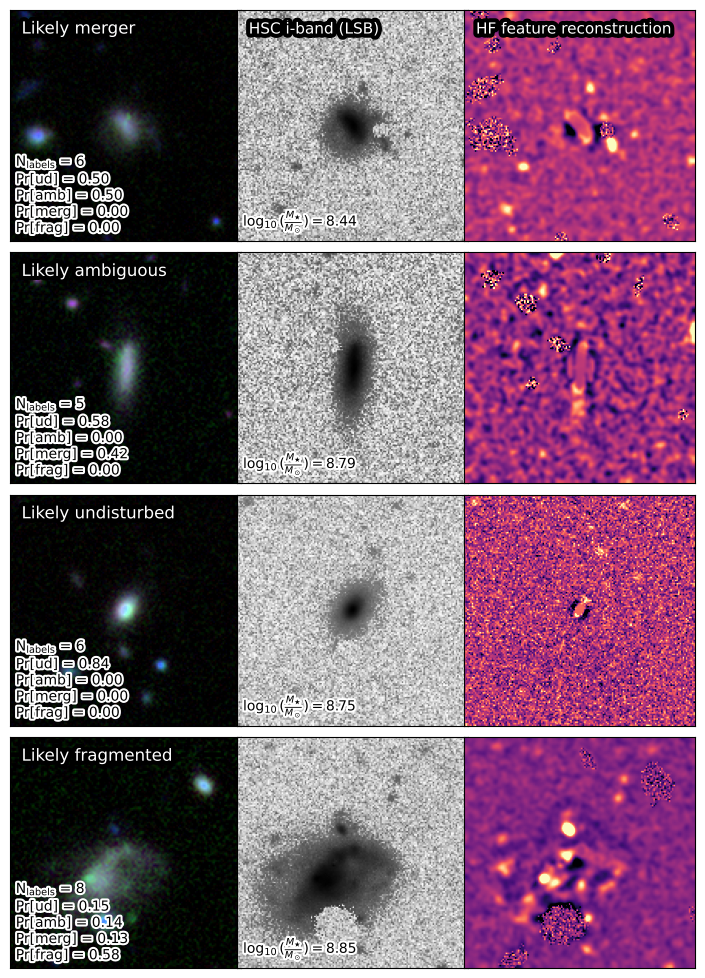

In [252]:
# Create the transposed grid: galaxies as rows, viz types as columns
n_galaxies = len(all_selected)
n_viz_types = 3

fig, axarr = plt.subplots(n_galaxies, n_viz_types, figsize=(8, 2.5*n_galaxies))

# Handle case where we only have one galaxy (axarr would be 1D)
if n_galaxies == 1:
    axarr = axarr.reshape(1, -1)

for row_idx, gix in enumerate(all_selected):
    # Column 0: r-N708-i RGB image
    bbmb = bbmb_d[gix]
    if bbmb is None:
        ek.imshow(
            images[gix][1],
            origin='lower',
            cmap='Greys',
            q=0.01,
            ax=axarr[row_idx,0]
        )
    else:
        ek.imshow(
            make_lupton_rgb( bbmb.image['r'], bbmb.image['N708'], bbmb.image['i'], Q=3, stretch=2.),
            ax=axarr[row_idx,0]
        )
    
    # Column 1: HSC i-band (LSB with SymLog normalization)
    axarr[row_idx, 1].imshow(
        images[gix][1],
        origin='lower',
        cmap='Greys',
        norm=colors.SymLogNorm(linthresh=0.1)
    )
    
    # Column 2: Starlet HF
    ek.imshow(
        images[gix][2],
        ax=axarr[row_idx, 2],
        cmap='magma',
        q=0.005
    )
    
    # Add probability labels to first column
    ek.text(
        0.025,
        0.025,
        rf'''N$_{{\rm labels}}$ = {n_labels[gix]}
Pr[ud] = {prob_labels[gix,1]:.2f}
Pr[amb] = {prob_labels[gix,2]:.2f}
Pr[merg] = {prob_labels[gix,3]:.2f}
Pr[frag] = {prob_labels[gix,4]:.2f}''',
        ax=axarr[row_idx, 0],
        fontsize=10,
        bordercolor='w',
        color='k',
        borderwidth=3
    )

    with open(f"{config['data']['input_path']}/{img_names[gix]}/{img_names[gix]}_i_results.pkl", 'rb') as f:
        x = pickle.load(f)
        logmstar = x['logmass_adjusted']

    ek.text(
        0.025,
        0.025,
        rf'''$\log_{{10}}(\frac{{M_{{\bigstar}}}}{{M_\odot}})={logmstar:.2f}$''',
        ax=axarr[row_idx, 1],
        fontsize=10,
        bordercolor='w',
        color='k',
        borderwidth=3
    )        

# Add column headers to top row
ek.text(0.05, 0.95, 'Likely merger', ax=axarr[0, 0], fontsize=12, bordercolor='k', color='w', borderwidth=6)
ek.text(0.05, 0.95, 'Likely ambiguous', ax=axarr[1, 0], fontsize=12, bordercolor='k', color='w', borderwidth=6)
ek.text(0.05, 0.95, 'Likely undisturbed', ax=axarr[2, 0], fontsize=12, bordercolor='k', color='w', borderwidth=6)
ek.text(0.05, 0.95, 'Likely fragmented', ax=axarr[3, 0], fontsize=12, bordercolor='k', color='w', borderwidth=6)

#ek.text(0.05, 0.95, 'HSC i-band', ax=axarr[0, 0], fontsize=12, bordercolor='k', color='w', borderwidth=6)
ek.text(0.05, 0.95, 'HSC i-band (LSB)', ax=axarr[0, 1], fontsize=11, bordercolor='k', color='w', borderwidth=6)
ek.text(0.05, 0.95, '''HF feature reconstruction''', ax=axarr[0, 2], fontsize=11, bordercolor='k', color='w', borderwidth=6)

# Remove ticks from all axes
for ax in axarr.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(wspace=-0.17, hspace=0.05)
plt.savefig(f'/Users/kadofong/work/papers/journal/MerianStarbursts/figures/galaxy_examples_{mode}.pdf', dpi=150, bbox_inches='tight')
#print(f"✅ Figure saved to ../figure_generation/galaxy_examples_transposed.png")